In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Data

In [2]:
# Load CFashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),
                         (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root='data',
                                             train=True,
                                             download=True,
                                             transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=1024,
                                          num_workers=10,
                                          shuffle=True,
                                          drop_last=True)

testset = torchvision.datasets.FashionMNIST(root='data',
                                            train=False,
                                            download=True,
                                            transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1024,
                                         num_workers=10,
                                         shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.1MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


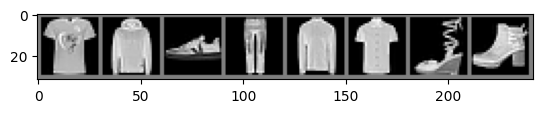

In [6]:
def imgshow(img):
  img = img*0.5+0.5
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))
  plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
  imgshow(torchvision.utils.make_grid(images[:8]))
  break

Model

In [10]:
class CustomModel(nn.Module):
  def __init__(self):
    super(CustomModel, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 7)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 7)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=7)
    self.conv4 = nn.Conv2d(128, 256, kernel_size=7)
    self.flatten = nn.Flatten()
    self.dense1 = nn.Linear(4*4*256, 128)
    self.dense2 = nn.Linear(128, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.relu(self.conv3(x))
    x = self.relu(self.conv4(x))
    x = self.flatten(x)
    x = self.relu(self.dense1(x))
    x = self.dense2(x)
    return x

model = CustomModel()
model = model.to(device)
# print
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 22, 22]           1,600
              ReLU-2           [-1, 32, 22, 22]               0
            Conv2d-3           [-1, 64, 16, 16]         100,416
              ReLU-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 10, 10]         401,536
              ReLU-6          [-1, 128, 10, 10]               0
            Conv2d-7            [-1, 256, 4, 4]       1,605,888
              ReLU-8            [-1, 256, 4, 4]               0
           Flatten-9                 [-1, 4096]               0
           Linear-10                  [-1, 128]         524,416
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 2,635,146
Trainable params: 2,635,146
Non-trainable params: 0
---------------------------

Loss, Optimizer, and Evaluation Function

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Loss and Accuracy Function for testset
def evaluate(model, testloader, criterion):
  model.eval()
  test_loss = 0.0
  running_correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in testloader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      test_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      running_correct += (predicted == labels).sum().item()

  accuracy = 100 * running_correct / total
  test_loss = test_loss /len(testloader)
  return test_loss, accuracy

Train

In [12]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 250

for epoch in range(max_epoch):
  model.train()
  running_loss = 0.0
  running_correct = 0
  total = 0

  for i, (inputs, labels) in enumerate(trainloader, 0):
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    running_correct += (predicted == labels).sum().item()

    loss.backward()
    optimizer.step()

  epoch_accuracy = 100 * running_correct / total
  epoch_loss = running_loss / (i + 1)

  test_loss, test_accuracy = evaluate(model, testloader, criterion)
  print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

  # save for plot
  train_losses.append(epoch_loss)
  train_accuracies.append(epoch_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/250], Loss: 2.2029, Accuracy: 30.70%, Test Loss: 1.9395, Test Accuracy: 43.66%
Epoch [2/250], Loss: 1.4602, Accuracy: 54.93%, Test Loss: 1.0845, Test Accuracy: 62.24%
Epoch [3/250], Loss: 0.9646, Accuracy: 65.56%, Test Loss: 0.9048, Test Accuracy: 67.34%
Epoch [4/250], Loss: 0.8606, Accuracy: 68.48%, Test Loss: 0.8427, Test Accuracy: 69.44%
Epoch [5/250], Loss: 0.8057, Accuracy: 70.58%, Test Loss: 0.8008, Test Accuracy: 71.04%
Epoch [6/250], Loss: 0.7668, Accuracy: 71.79%, Test Loss: 0.7670, Test Accuracy: 71.36%
Epoch [7/250], Loss: 0.7347, Accuracy: 73.01%, Test Loss: 0.7370, Test Accuracy: 72.71%
Epoch [8/250], Loss: 0.7081, Accuracy: 73.64%, Test Loss: 0.7145, Test Accuracy: 73.45%
Epoch [9/250], Loss: 0.6844, Accuracy: 74.46%, Test Loss: 0.6957, Test Accuracy: 73.63%
Epoch [10/250], Loss: 0.6666, Accuracy: 74.80%, Test Loss: 0.6768, Test Accuracy: 74.42%
Epoch [11/250], Loss: 0.6506, Accuracy: 75.40%, Test Loss: 0.6649, Test Accuracy: 74.86%
Epoch [12/250], Loss: 0.6367, 

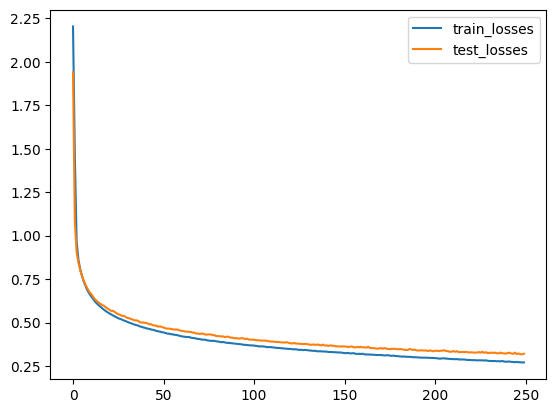

In [13]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

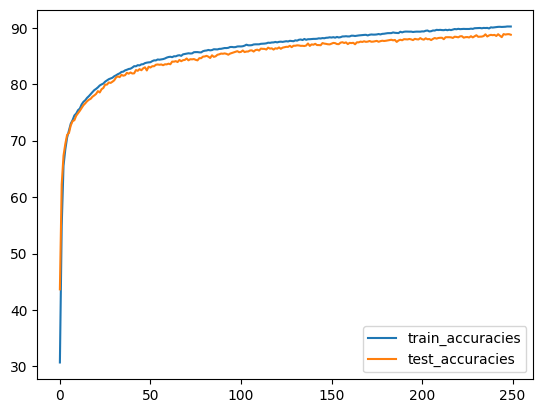

In [14]:
plt.plot(train_accuracies, label='train_accuracies')
plt.plot(test_accuracies, label = 'test_accuracies')
plt.legend()